# Predictive Modelling using Machine Learning Algorithms

In [1]:
import pandas as pd
import numpy as np
import duckdb as db
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import optuna
import warnings
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
# pd.set_option('plotting.backend', 'plotly')
# pio.renderers.default = "notebook_connected"
optuna.logging.set_verbosity(optuna.logging.ERROR)
from sklearn.linear_model import LinearRegression
# elastic net
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
# lightgbm
import lightgbm as lgb
from lightgbm import LGBMRegressor

# xgboost
import xgboost as xgb
from xgboost import XGBRegressor

import mlflow
import pickle

import os

In [2]:
from notifier import send_notification, send_image, send_email

In [3]:
orig = pd.read_parquet("../../data/processed/train_enhanced.parquet")

In [4]:
orig

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,Orders,Sales,...,Year,Quarter,Week,Week_of_Month,Is_Weekend,cluster,log_Sales,log_Orders,sqrt_Sales,sqrt_Orders
0,T1000001,1,S1,L3,R1,2018-01-01,1,1,9,7011.84,...,2018,1,1,1,0,3,8.855498,2.302585,83.736730,3.000000
1,T1000002,253,S4,L2,R1,2018-01-01,1,1,60,51789.12,...,2018,1,1,1,0,2,10.854955,4.110874,227.572230,7.745967
2,T1000003,252,S3,L2,R1,2018-01-01,1,1,42,36868.20,...,2018,1,1,1,0,1,10.515132,3.761200,192.010937,6.480741
3,T1000004,251,S2,L3,R1,2018-01-01,1,1,23,19715.16,...,2018,1,1,1,0,4,9.889194,3.178054,140.410683,4.795832
4,T1000005,250,S2,L3,R4,2018-01-01,1,1,62,45614.52,...,2018,1,1,1,0,4,10.728003,4.143135,213.575560,7.874008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188335,T1188336,149,S2,L3,R2,2019-05-31,1,1,51,37272.00,...,2019,2,22,5,0,4,10.526024,3.951244,193.059576,7.141428
188336,T1188337,153,S4,L2,R1,2019-05-31,1,0,90,54572.64,...,2019,2,22,5,0,2,10.907306,4.510860,233.607877,9.486833
188337,T1188338,154,S1,L3,R2,2019-05-31,1,0,56,31624.56,...,2019,2,22,5,0,3,10.361721,4.043051,177.832955,7.483315
188338,T1188339,155,S3,L1,R2,2019-05-31,1,1,70,49162.41,...,2019,2,22,5,0,1,10.802905,4.262680,221.725980,8.366600


In [5]:
print("Min date:", orig["Date"].min(), ", Max date:", orig["Date"].max())

total_days = (orig["Date"].max() - orig["Date"].min()).days
train_max = orig["Date"].min() + pd.DateOffset(days=total_days * 0.8)
print("Total days:", total_days, ", Training days: ",total_days * 0.8 )
print("Train max date:", train_max)


Min date: 2018-01-01 00:00:00 , Max date: 2019-05-31 00:00:00
Total days: 515 , Training days:  412.0
Train max date: 2019-02-17 00:00:00


In [6]:
orig.columns

Index(['ID', 'Store_id', 'Store_Type', 'Location_Type', 'Region_Code', 'Date',
       'Holiday', 'Discount', 'Orders', 'Sales', 'Day_of_Week_Name', 'Day',
       'Day_of_Week', 'Month_Name', 'Month', 'Year', 'Quarter', 'Week',
       'Week_of_Month', 'Is_Weekend', 'cluster', 'log_Sales', 'log_Orders',
       'sqrt_Sales', 'sqrt_Orders'],
      dtype='object')

In [7]:
columns = ['Store_id', 'Store_Type', 'Location_Type', 'Region_Code',
       'Holiday', 'Discount',  'Sales', 'Day', 'Date',
       'Day_of_Week', 'Month', 'Quarter', 'Week',
       'Week_of_Month', 'Is_Weekend', "cluster"]

In [8]:
df=orig[columns]

In [9]:
orig["Orders"].describe()

count    188340.000000
mean         68.205692
std          30.467415
min           0.000000
25%          48.000000
50%          63.000000
75%          82.000000
max         371.000000
Name: Orders, dtype: float64

In [10]:
train = df[df["Date"] <= train_max]
test = df[df["Date"] > train_max - pd.DateOffset(days=30)]

# Feature Engineering

In [11]:
def generate_features(result, drop_na=True):
    # # Register the resultFrame as a temporary table
    # db.sql(f"CREATE OR REPLACE TEMPORARY TABLE {table_name} AS SELECT * FROM result")

    # query = f"""
    # SELECT *,
    #     lag(Sales, 1) over (partition by Store_id order by Date) as Sales_Lag_1,
    #     lag(Sales, 7) over (partition by Store_id order by Date) as Sales_Lag_7,
    #     lag(Sales, 12) over (partition by Store_id order by Date) as Sales_Lag_12,
    #     lag(Sales, 30) over (partition by Store_id order by Date) as Sales_Lag_30,
    #     avg(Sales) over (partition by Store_id order by Date rows between 7 preceding and 1 preceding) as Sales_Mean_7,
    #     avg(Sales) over (partition by Store_id order by Date rows between 12 preceding and 1 preceding) as Sales_Mean_12,
    #     avg(Sales) over (partition by Store_id order by Date rows between 30 preceding and 1 preceding) as Sales_Mean_30,
    #     stddev_pop(Sales) over (partition by Store_id order by Date rows between 7 preceding and 1 preceding) as Sales_Std_7,
    #     stddev_pop(Sales) over (partition by Store_id order by Date rows between 12 preceding and 1 preceding) as Sales_Std_12,
    #     stddev_pop(Sales) over (partition by Store_id order by Date rows between 30 preceding and 1 preceding) as Sales_Std_30,
    #     avg(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Mean,
    #     stddev_pop(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Std,
    #     sum(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Sum,
    #     --min(Sales) over (partition by Store_id order by Date rows between unbounded preceding and 1 preceding) as Sales_Expanding_Min,
    # from {table_name}
    # """
    
    # result = db.sql(query).df()


    result = result.sort_values(by=['Store_id', 'Date'])

    # Create lag features
    result['Sales_Lag_1'] = result.groupby('Store_id')['Sales'].shift(1)
    result['Sales_Lag_7'] = result.groupby('Store_id')['Sales'].shift(7)
    result['Sales_Lag_12'] = result.groupby('Store_id')['Sales'].shift(12)
    result['Sales_Lag_30'] = result.groupby('Store_id')['Sales'].shift(30)

    # Create moving average features
    result['Sales_Mean_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).mean()
    result['Sales_Mean_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).mean()
    result['Sales_Mean_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).mean()

    # result['Sales_EMA_7'] = result.groupby('Store_id')['Sales'].shift(1).ewm(span=7, adjust=False).mean()
    # result['Sales_EMA_12'] = result.groupby('Store_id')['Sales'].shift(1).ewm(span=12, adjust=False).mean()
    # result['Sales_EMA_30'] = result.groupby('Store_id')['Sales'].shift(1).ewm(span=30, adjust=False).mean()

    # Create moving standard deviation features
    result['Sales_Std_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).std()
    result['Sales_Std_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).std()
    result['Sales_Std_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).std()

    # create moving min and max features
    result['Sales_Min_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).min()
    result['Sales_Min_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).min()
    result['Sales_Min_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).min()

    result['Sales_Max_7'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=7).max()
    result['Sales_Max_12'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=12).max()
    result['Sales_Max_30'] = result.groupby('Store_id')['Sales'].shift(1).rolling(window=30).max()
    

    # Create expanding mean and standard deviation features
    result['Sales_Expanding_Mean'] = result.groupby('Store_id')['Sales'].shift(1).ewm(alpha=0.9, adjust=False).mean()
    # result['Sales_Expanding_Weighted_Mean'] = result.groupby('Store_id')['Sales'].expanding().apply(lambda x: np.average(x, weights=np.arange(1, len(x)+1))).shift(1).reset_index(level=0, drop=True)
    result['Sales_Expanding_Std'] = result.groupby('Store_id')['Sales'].shift(1).ewm(alpha=0.9, adjust=False).std()
    result['Sales_Expanding_Sum'] = result.groupby('Store_id')['Sales'].expanding().sum().shift(1).reset_index(level=0, drop=True)

    
    result = result.drop(columns=["Date"], axis=1)
    # encode cyclical features
    result['Day_sin'] = np.sin(2 * np.pi * result['Day']/31)
    result['Day_cos'] = np.cos(2 * np.pi * result['Day']/31)

    result['Day_of_Week_sin'] = np.sin(2 * np.pi * result['Day_of_Week']/6)
    result['Day_of_Week_cos'] = np.cos(2 * np.pi * result['Day_of_Week']/6)

    result['Month_sin'] = np.sin(2 * np.pi * result['Month']/12)
    result['Month_cos'] = np.cos(2 * np.pi * result['Month']/12)

    result['Quarter_sin'] = np.sin(2 * np.pi * result['Quarter']/4)
    result['Quarter_cos'] = np.cos(2 * np.pi * result['Quarter']/4)

    result['Week_sin'] = np.sin(2 * np.pi * result['Week']/52)
    result['Week_cos'] = np.cos(2 * np.pi * result['Week']/52)

    result['Week_of_Month_sin'] = np.sin(2 * np.pi * result['Week_of_Month']/5)
    result['Week_of_Month_cos'] = np.cos(2 * np.pi * result['Week_of_Month']/5)

    # add fourier features for 7 days, 12 days, 30 days
    # result['Day_7_sin'] = np.sin(2 * np.pi * result['Day']/7)
    # result['Day_7_cos'] = np.cos(2 * np.pi * result['Day']/7)

    # result['Day_12_sin'] = np.sin(2 * np.pi * result['Day']/12)
    # result['Day_12_cos'] = np.cos(2 * np.pi * result['Day']/12)

    # drop original cyclical features
    result = result.drop(columns=['Day', 'Day_of_Week', 'Month', 'Quarter', 'Week', 'Week_of_Month'], axis=1)

    if drop_na:
        result = result.dropna()
        
    return result




In [12]:
train = generate_features(train, drop_na=True)
test = generate_features(test, drop_na=True)

In [13]:
ohe = OneHotEncoder(categories='auto')
feature_array = ohe.fit_transform(train[['Store_Type', 'Location_Type', 'Region_Code', 'cluster']]).toarray()
train = pd.concat([train.reset_index(drop=True), pd.DataFrame(feature_array, columns=ohe.get_feature_names_out()).reset_index(drop=True)], axis=1).drop(['Store_Type', 'Location_Type', 'Region_Code', 'cluster'], axis=1)

feature_array = ohe.transform(test[['Store_Type', 'Location_Type', 'Region_Code', 'cluster']]).toarray()
test = pd.concat([test.reset_index(drop=True), pd.DataFrame(feature_array, columns=ohe.get_feature_names_out()).reset_index(drop=True)], axis=1).drop(['Store_Type', 'Location_Type', 'Region_Code', 'cluster'], axis=1)

store_id_encoder = TargetEncoder()
train['Store_id_encoded'] = store_id_encoder.fit_transform(train[['Store_id']], train['Sales'])
test['Store_id_encoded'] = store_id_encoder.transform(test[['Store_id']])

train = train.drop(columns=['Store_id'], axis=1)
test = test.drop(columns=['Store_id'], axis=1)

In [14]:
with open("./pickles/train_features.pkl", "wb") as f:
    pickle.dump(train, f)

with open("./pickles/test_features.pkl", "wb") as f:
    pickle.dump(test, f)

In [6]:
with open("./pickles/train_features.pkl", "rb") as f:
    train = pickle.load(f)

with open("./pickles/test_features.pkl", "rb") as f:
    test = pickle.load(f)

In [15]:
train.columns

Index(['Holiday', 'Discount', 'Sales', 'Is_Weekend', 'Sales_Lag_1',
       'Sales_Lag_7', 'Sales_Lag_12', 'Sales_Lag_30', 'Sales_Mean_7',
       'Sales_Mean_12', 'Sales_Mean_30', 'Sales_Std_7', 'Sales_Std_12',
       'Sales_Std_30', 'Sales_Min_7', 'Sales_Min_12', 'Sales_Min_30',
       'Sales_Max_7', 'Sales_Max_12', 'Sales_Max_30', 'Sales_Expanding_Mean',
       'Sales_Expanding_Std', 'Sales_Expanding_Sum', 'Day_sin', 'Day_cos',
       'Day_of_Week_sin', 'Day_of_Week_cos', 'Month_sin', 'Month_cos',
       'Quarter_sin', 'Quarter_cos', 'Week_sin', 'Week_cos',
       'Week_of_Month_sin', 'Week_of_Month_cos', 'Store_Type_S1',
       'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Region_Code_R1', 'Region_Code_R2',
       'Region_Code_R3', 'Region_Code_R4', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'Store_id_encoded'],
      dtype='object')

In [16]:
scaler = StandardScaler()

X_train = train.drop(columns=["Sales"])
X_test = test.drop(columns=["Sales"])

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=train.drop(["Sales"], axis=1).columns)
X_test = pd.DataFrame(X_test, columns=test.drop(["Sales"], axis=1).columns)

y_train = train["Sales"]
y_test = test["Sales"]

In [17]:
X_train

,Holiday,Discount,Is_Weekend,Sales_Lag_1,Sales_Lag_7,Sales_Lag_12,Sales_Lag_30,Sales_Mean_7,Sales_Mean_12,Sales_Mean_30,...,Location_Type_L5,Region_Code_R1,Region_Code_R2,Region_Code_R3,Region_Code_R4,cluster_1,cluster_2,cluster_3,cluster_4,Store_id_encoded
0,2.610810,-0.909804,-0.634768,-1.447014,0.288929,-0.729410,-1.968398,0.000016,-0.207151,-0.366941,...,-0.282633,1.394112,-0.635489,-0.555197,-0.39841,-0.389127,-0.567859,1.177124,-0.508548,-0.634943
1,-0.383023,-0.909804,-0.634768,-1.474064,0.154144,-0.583216,-0.026322,-0.314159,-0.287953,-0.345278,...,-0.282633,1.394112,-0.635489,-0.555197,-0.39841,-0.389127,-0.567859,1.177124,-0.508548,-0.634943
2,-0.383023,-0.909804,-0.634768,-0.838399,-0.919033,0.115135,0.394861,-0.491527,-0.315856,-0.382354,...,-0.282633,1.394112,-0.635489,-0.555197,-0.39841,-0.389127,-0.567859,1.177124,-0.508548,-0.634943
3,-0.383023,-0.909804,1.575379,-0.466227,0.440377,0.090507,0.085070,-0.411407,-0.379198,-0.421741,...,-0.282633,1.394112,-0.635489,-0.555197,-0.39841,-0.389127,-0.567859,1.177124,-0.508548,-0.634943
4,-0.383023,-0.909804,1.575379,-0.544710,1.285550,-0.797623,0.261222,-0.587744,-0.448359,-0.450738,...,-0.282633,1.394112,-0.635489,-0.555197,-0.39841,-0.389127,-0.567859,1.177124,-0.508548,-0.633698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139790,-0.383023,-0.909804,-0.634768,-0.674796,1.075535,-1.142990,-0.171930,-0.595030,-0.562455,-0.676557,...,-0.282633,-0.717302,1.573592,-0.555197,-0.39841,-0.389127,-0.567859,-0.849528,1.966384,-0.936061
139791,-0.383023,1.099137,-0.634768,-1.261675,-1.171769,0.122917,-0.438640,-1.011870,-0.575464,-0.725944,...,-0.282633,-0.717302,1.573592,-0.555197,-0.39841,-0.389127,-0.567859,-0.849528,1.966384,-0.988763
139792,-0.383023,1.099137,-0.634768,-0.484147,-0.756030,-0.049602,-1.211930,-0.889838,-0.641588,-0.728778,...,-0.282633,-0.717302,1.573592,-0.555197,-0.39841,-0.389127,-0.567859,-0.849528,1.966384,-0.988763
139793,-0.383023,1.099137,1.575379,-0.741332,-0.583795,-0.557885,-0.937403,-0.887601,-0.716827,-0.708406,...,-0.282633,-0.717302,1.573592,-0.555197,-0.39841,-0.389127,-0.567859,-0.849528,1.966384,-0.988763


In [18]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


# Linear Regression

In [19]:
mlflow.set_experiment("Linear Regression")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "Default Run")
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)

# Elastic Net Regression

In [20]:
mlflow.set_experiment("ElasitcNet")
def objective_elastic(trial):
    with mlflow.start_run():
        params = {
            "alpha": trial.suggest_float('alpha', 0.0, 1.0),
            "l1_ratio": trial.suggest_float('l1_ratio', 0.0, 1.0)
        }
        en = ElasticNet(**params, random_state=42)
        en.fit(X_train, y_train)
        y_pred = en.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective_elastic, n_trials=50)

# Random Forest

In [119]:
mlflow.set_experiment("Random Forest Default")
with mlflow.start_run():
    mlflow.set_tag("mlflow.runName", "f_run")
    params = {
        "n_estimators": 80,
        # "max_depth": 8,
    }
    rf = RandomForestRegressor(n_jobs=-1, **params)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)
    mlflow.log_params(params)

In [120]:
mean_absolute_error(y_test, y_pred)

6556.791274835803

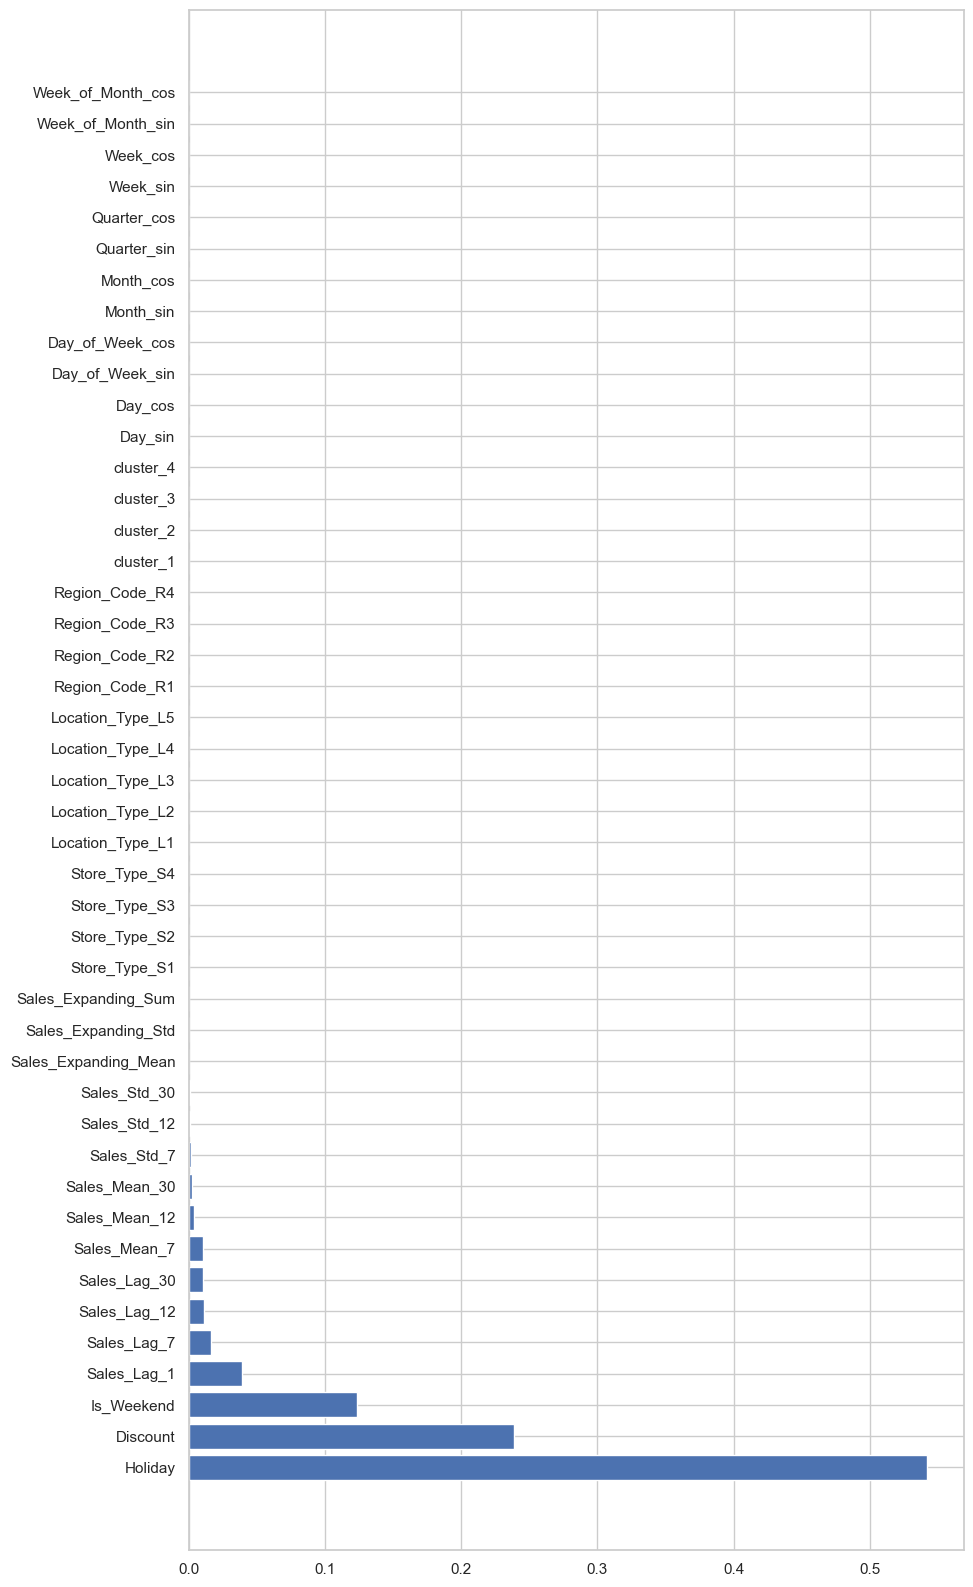

In [102]:
# plot the feature importance
plt.figure(figsize=(10, 20))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns, importances[indices])
plt.show()

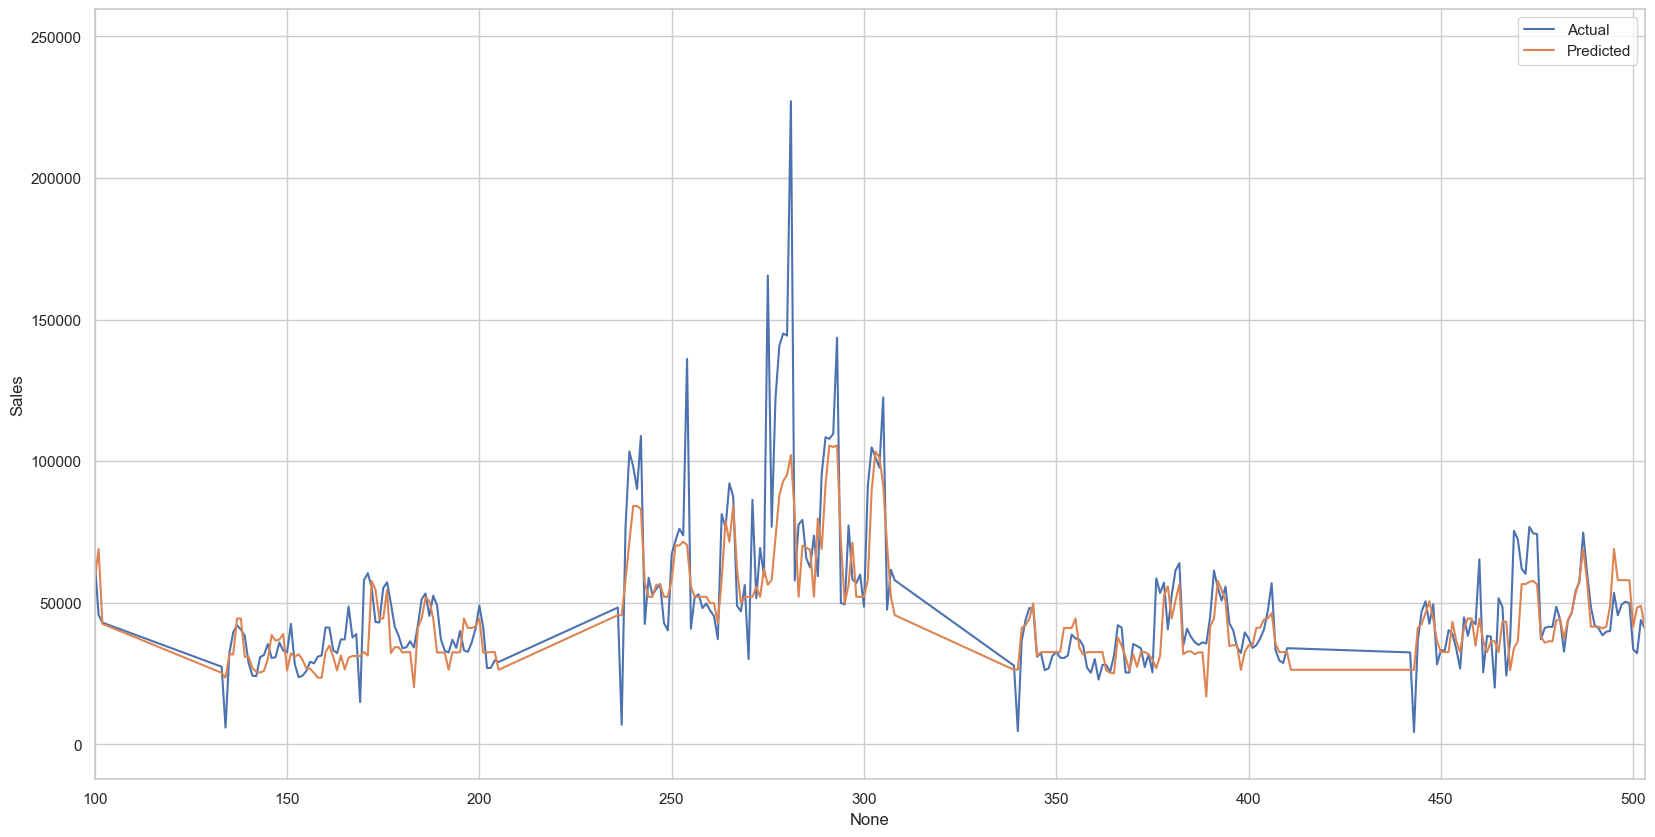

In [105]:
plt.figure(figsize=(20,10))
sns.lineplot(x=test.index, y=y_test, label="Actual")
sns.lineplot(x=test.index, y=y_pred, label="Predicted")
# show only first 100 days
plt.xlim(100,503)
plt.show()

In [106]:
mean_absolute_error(y_test, y_pred)

7965.476355682496

In [56]:
y_train_pred = rf.predict(X_train)
mean_absolute_error(y_train, y_train_pred)

1456.491097928395

In [139]:
study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="Sales Forecasting", load_if_exists=True)

In [140]:
mlflow.set_experiment("Random Forest Optuna")
def objective_rf(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 200),
            "max_depth": trial.suggest_int("max_depth", 7, 32),
        }
        rf = RandomForestRegressor(**params, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae
study.optimize(objective_rf, n_trials=10)

In [142]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 80,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [84]:
study.best_params

{'n_estimators': 400,
 'max_depth': 7,
 'min_samples_split': 5,
 'min_samples_leaf': 3}

# LightGBM

In [86]:
mlflow.set_experiment("LightGBM Optuna")
def objective_lgb(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 200),
            "max_depth": trial.suggest_int("max_depth", 7, 32),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 31, 127),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "boosting_type": "goss",
            "num_threads": 16,
        }
        lgbm = LGBMRegressor(**params, n_jobs=-1)
        lgbm.fit(X_train, y_train)
        y_pred = lgbm.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae

study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="LightGBM", load_if_exists=True)
study.optimize(objective_lgb, n_trials=50)
send_notification("Optuna LightGBM completed")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5348
[LightGBM] [Info] Number of data points in the train set: 139795, number of used features: 52
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 42508.380824
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_

In [10]:
study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="LightGBM", load_if_exists=True)

In [87]:
mlflow.set_experiment("LightGBM")
with mlflow.start_run():
    lgbm = LGBMRegressor(**study.best_params, n_jobs=-1, random_state=42, num_threads=16, boosting_type="goss")
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)
    mlflow.log_params(study.best_params)
    mlflow.sklearn.log_model(lgbm, "lgbm")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5348
[LightGBM] [Info] Number of data points in the train set: 139795, number of used features: 52
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 42508.380824
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_

2025/01/09 20:40:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [88]:
y_pred = lgbm.predict(X_test)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.


In [89]:
study.best_params

{'n_estimators': 197,
 'max_depth': 19,
 'learning_rate': 0.06969300936939352,
 'num_leaves': 61,
 'subsample': 0.8296658570736767}

In [90]:
mae

6179.741462569809

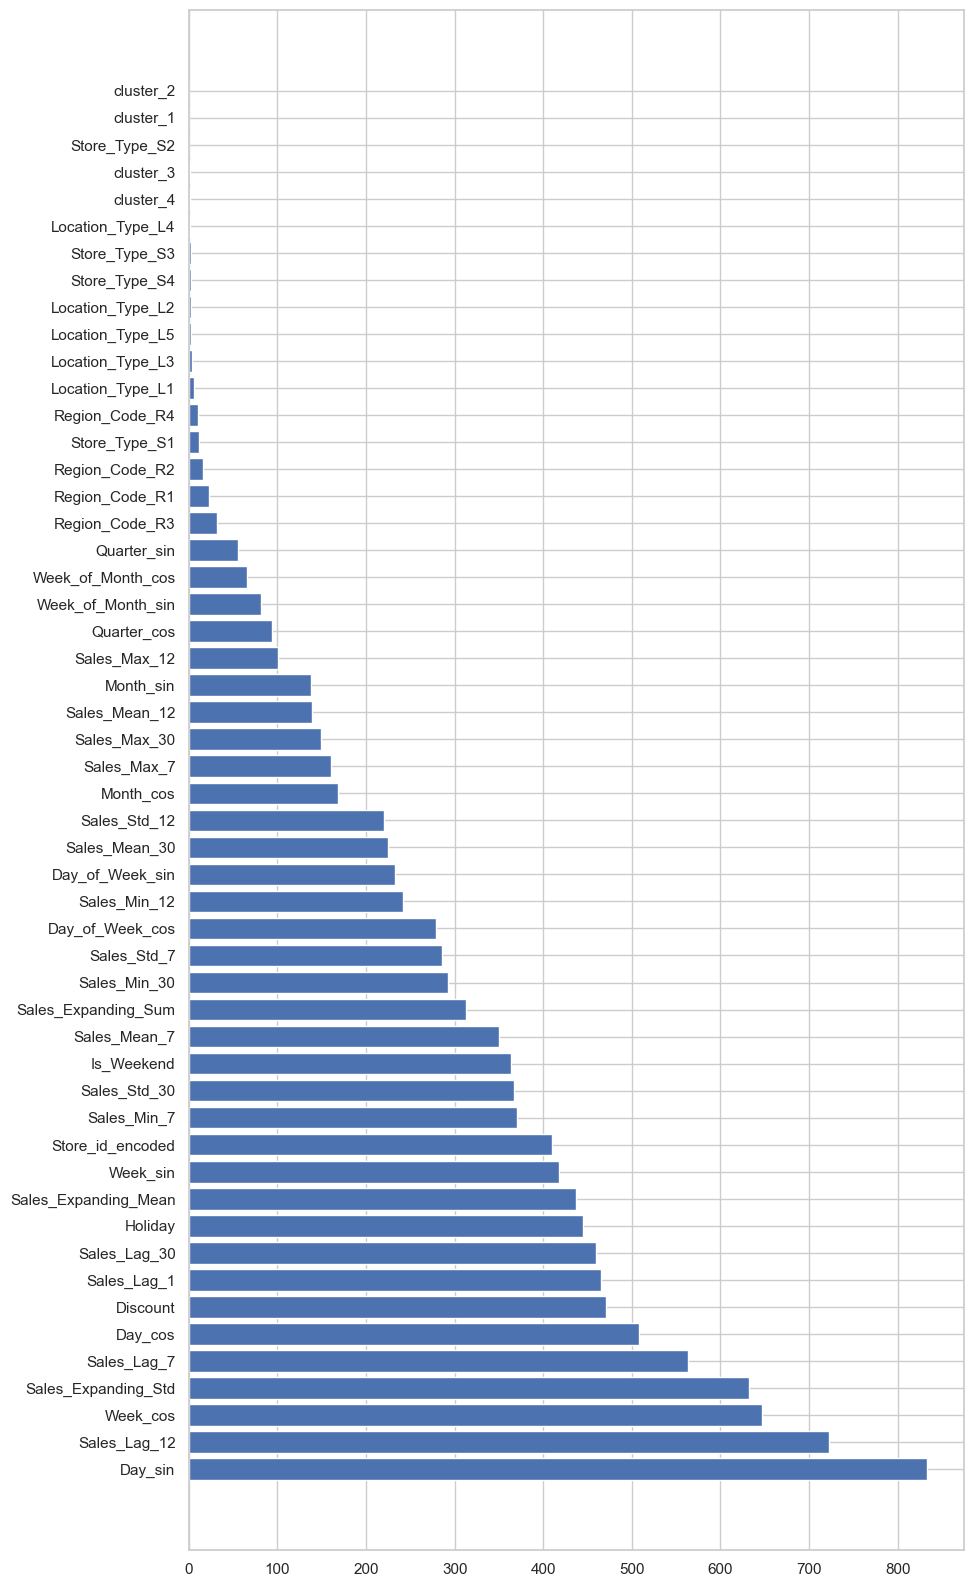

In [91]:
# plot the feature importance
plt.figure(figsize=(10, 20))
importances = lgbm.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns[indices], importances[indices])
plt.show()

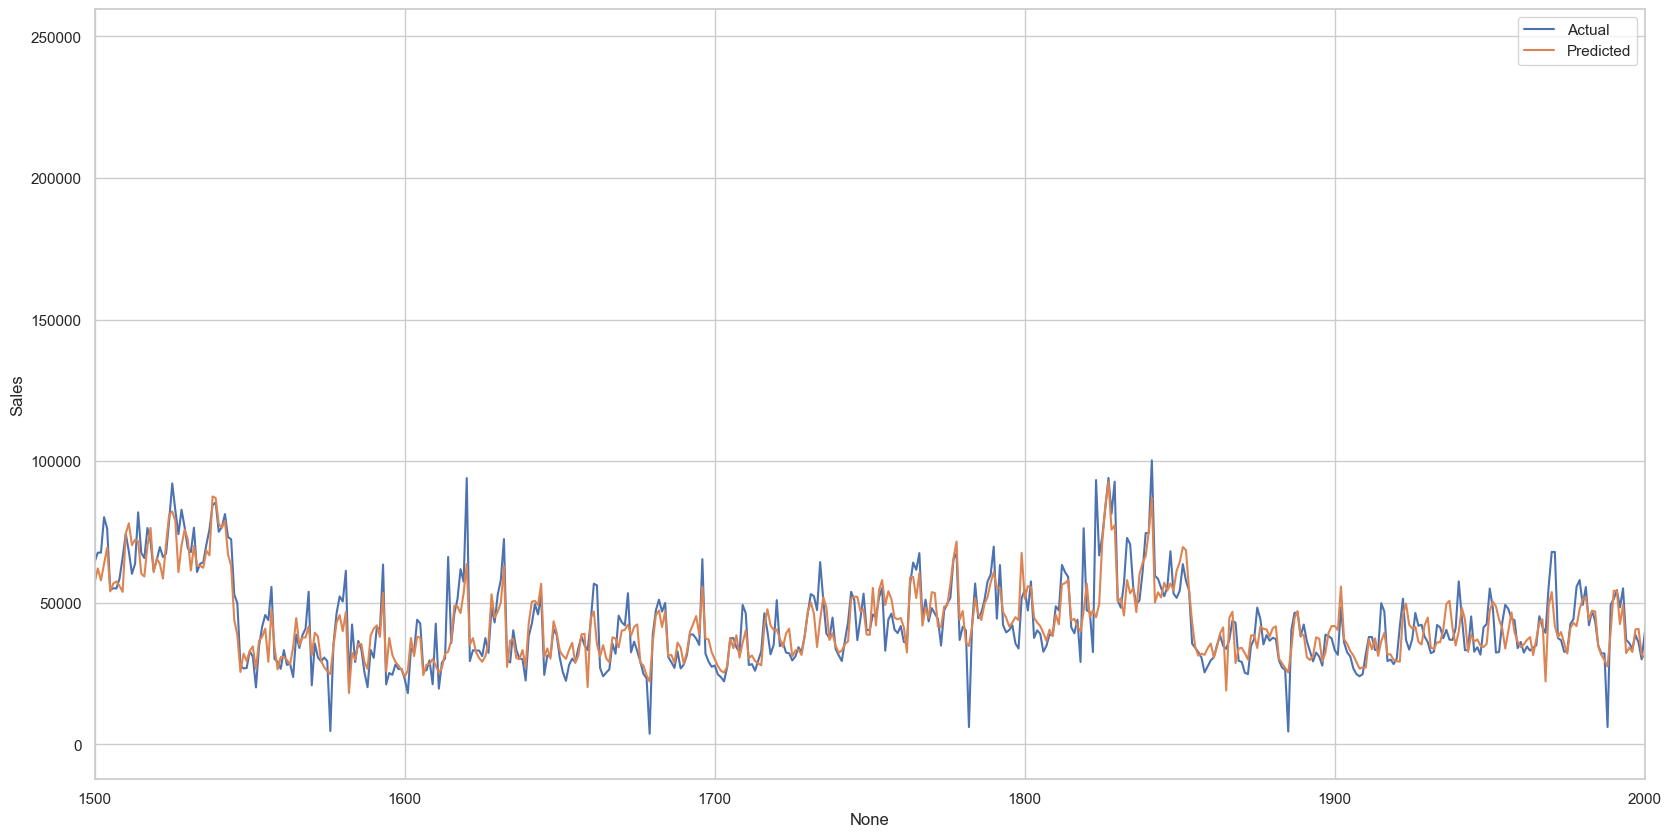

In [94]:
plt.figure(figsize=(20,10))
sns.lineplot(x=test.index, y=y_test, label="Actual")
sns.lineplot(x=test.index, y=y_pred, label="Predicted")
# show only first 100 days
plt.xlim(1500,2000)
plt.show()

# XGBoost

In [123]:
mlflow.set_experiment("XGBoost")
with mlflow.start_run():
    xgb = XGBRegressor(n_jobs=-1, random_state=42, device='gpu')
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)

In [38]:
mlflow.set_experiment("XGBoost Optuna")
def objective_xgb(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 300),
            "max_depth": trial.suggest_int("max_depth", 7, 32),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "num_leaves": trial.suggest_int("num_leaves", 31, 127),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),

        }
        xgb = XGBRegressor(**params, n_jobs=-1)   
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mlflow.log_metric("mae", mae)
        mlflow.log_params(params)
        return mae

study = optuna.create_study(direction="minimize", storage="sqlite:///optuna.db", study_name="XGBoost", load_if_exists=True)
study.optimize(objective_xgb, n_trials=20)
send_notification("Optuna XGBoost completed")

In [139]:
mlflow.set_experiment("XGBoost")
with mlflow.start_run():
    xgb = XGBRegressor(n_jobs=-1, random_state=42, **study.best_params)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mlflow.log_metric("mae", mae)
    send_message(f"XGBoost MAE: {mae}")

In [127]:
mean_absolute_error(y_test, y_pred)

6596.9120768495495

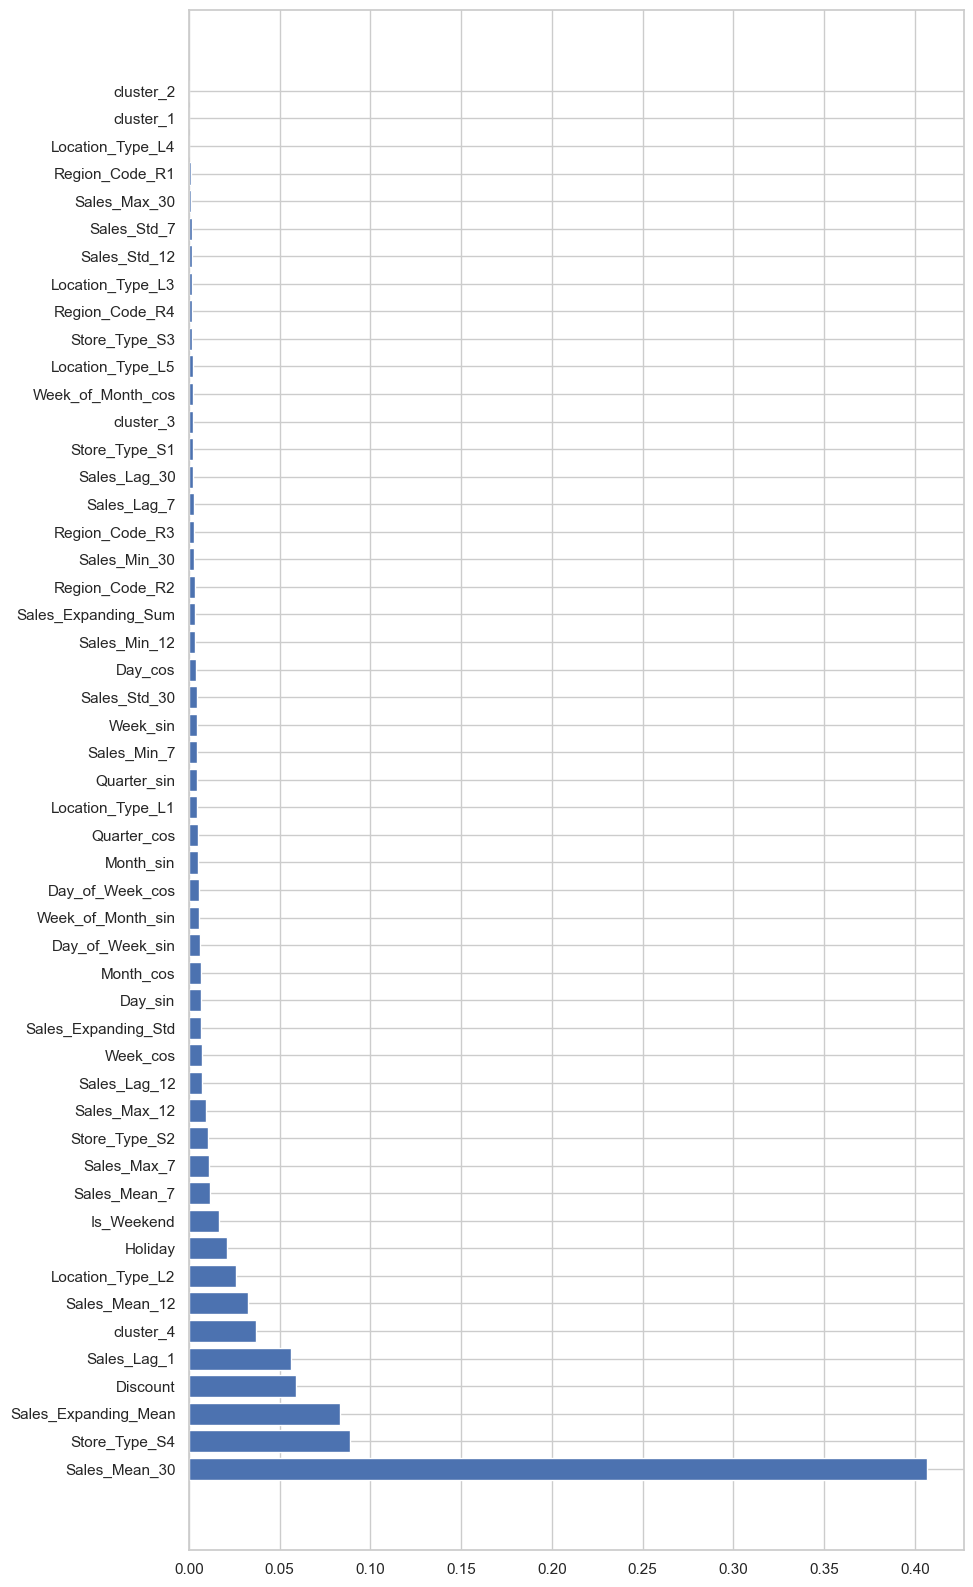

In [130]:
# plot the feature importance
plt.figure(figsize=(10, 20))
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X_train.columns[indices], importances[indices])
plt.show()